In [35]:
import pandas as pd
from datetime import date, datetime, timedelta
import pickle
import numpy as np
from math import sqrt
import copy
import matplotlib.pyplot as plt
%matplotlib inline

<h3> The below lines of code are a duplication of the code in teh GUI used to determine hotspots <h3>

In [36]:
NUM_HOTSPOTS = 15

In [37]:
def open_file():
    try:
        DATA_FILE = pd.read_csv(DEFAULT_FILE_PATH+ CSV_FILE_EXTENSION)
    except:
        print("File not found")
    return DATA_FILE

In [38]:
# Define file variables
DEFAULT_FILE_PATH = "CrimeGUI/data"
CSV_FILE_EXTENSION = ".csv"
DATA_FILE = pd.DataFrame()
FILTERED_DATA = pd.DataFrame()
DATA_FILE = open_file()
FIRST_DATE = datetime.strptime(DATA_FILE['Date'].iloc[0], '%Y-%m-%d')
LAST_DATE = datetime.strptime(DATA_FILE['Date'].iloc[len(DATA_FILE) - 1], '%Y-%m-%d')
MODEL_FEATURE_SEPARATOR = "_"
MODEL_PATH = "CrimeGUI/Models/"
COMMA_SPACE = ", "
INCIDENT_COL_KEY = "Todays Reports"
NEIGHBOURHOOD_COL_KEY = "Neighborhood"
DATE_COL_KEY = "Date"

In [39]:
# Define feature selection variables
F_REGRESSION_NAME = "F-Regression"
F_REGRESSION_FILE_TAG = "f_regression"
CHI2_NAME = "Chi-Squared"
CHI2_FILE_TAG = "chi2"
ADABOOST_NAME = "AdaBoost"
ADABOOST_FILE_TAG = "adaboost"
EQUAL_DATA_NAME = "Equal Selection"
EQUAL_DATA_FILE_TAG = "equal_crime_and_business"
ALL_BUS_NAME = "All Business"
ALL_BUS_FILE_TAG = "all_business"
FEATURE_SELECTION = [F_REGRESSION_NAME, CHI2_NAME, ADABOOST_NAME, EQUAL_DATA_NAME, ALL_BUS_NAME]
FEATURES = {
    F_REGRESSION_NAME : ['Reports 1 day ago', 'Reports 2 days ago', 'Reports 3 days ago',
                       'Reports 4 days ago', 'Reports 5 days ago', 'Reports 6 days ago',
                      'Reports 7 days ago','Reports 14 days ago','Reports 30 days ago','Reports 365 days ago'],
    CHI2_NAME : ['South of Market', 'Mission', 'Tenderloin', 'Number of businesses', 
               'Downtown / Union Square', 'Civic Center', 'Reports 365 days ago',
               'Reports 1 day ago','Reports 2 days ago','Reports 14 days ago'],
    ADABOOST_NAME : ['Reports 365 days ago', 'Reports 1 day ago', 'Reports 14 days ago', 'Reports 3 days ago', 
               'Reports 2 days ago', 'Reports 7 days ago', 'Number of businesses',
               'Reports 4 days ago','Reports 5 days ago','Closures 365 days ago'],
    EQUAL_DATA_NAME : ['Number of businesses', 'Last 28 days closures', 'Last 7 days openings',
                          'Last 14 days closures', 'Last 7 days closures','Reports 1 day ago',
                      'Reports 2 days ago', 'Reports 4 days ago', 'Reports 30 days ago', 'Reports 7 days ago'],
    ALL_BUS_NAME : ['Number of businesses', 'Last 28 days closures', 'Last 7 days openings',
                          'Last 14 days closures', 'Last 7 days closures','Number of openings',
                   'Openings 4 days ago','Openings 1 day ago', 'Openings 7 days ago', 'Openings 2 days ago']
    }
FEATURE_FILE_TAGS = {
    F_REGRESSION_NAME : F_REGRESSION_FILE_TAG,
    CHI2_NAME : CHI2_FILE_TAG,
    ADABOOST_NAME : ADABOOST_FILE_TAG,
    EQUAL_DATA_NAME : EQUAL_DATA_FILE_TAG,
    ALL_BUS_NAME : ALL_BUS_FILE_TAG
    }
FEATURE_NAMES_BY_FILE_TAG = {
    F_REGRESSION_FILE_TAG : F_REGRESSION_NAME,
    CHI2_FILE_TAG : CHI2_NAME,
    ADABOOST_FILE_TAG : ADABOOST_NAME,
    EQUAL_DATA_FILE_TAG : EQUAL_DATA_NAME,
    ALL_BUS_FILE_TAG : ALL_BUS_NAME
}

In [40]:
# Define model variables
DECISION_TREE_NAME = "Decision Tree"
DECISION_TREE_FILE_TAG = "decision_tree"
LINERAR_REGRESSION_NAME = "Linear \nRegression"
LINERAR_REGRESSION_FILE_TAG = "linear_regression"
RIDGE_REGRESSION_NAME = "Ridge \nRegression"
RIDGE_REGRESSION_FILE_TAG = "ridge_regression"
SVM_NAME = "SVM"
SVM_FILE_TAG = "svm"
MODELS = [DECISION_TREE_NAME,
          LINERAR_REGRESSION_NAME,
          RIDGE_REGRESSION_NAME,
          SVM_NAME]
MODEL_FILE_TAGS = {
    DECISION_TREE_NAME : DECISION_TREE_FILE_TAG,
    LINERAR_REGRESSION_NAME: LINERAR_REGRESSION_FILE_TAG,
    RIDGE_REGRESSION_NAME: RIDGE_REGRESSION_FILE_TAG,
    SVM_NAME : SVM_FILE_TAG
    }
MODEL_NAMES_BY_FILE_TAG = {
    DECISION_TREE_FILE_TAG : DECISION_TREE_NAME,
    LINERAR_REGRESSION_FILE_TAG : LINERAR_REGRESSION_NAME,
    RIDGE_REGRESSION_FILE_TAG : RIDGE_REGRESSION_NAME,
    SVM_FILE_TAG : SVM_NAME
}

In [41]:
PARENT_NEIGHBOURHOODS = {
    "Central Waterfront" : ["Dogpatch"],
    "Eureka Valley" : ["Dolores Heights","Castro"],
    "Buena Vista" : ["Ashbury Heights"],
    "Cole Valley" : ["Parnassus Heights"],
    "Bayview" : ["Apparel City", "Produce Market"],
    "Russian Hill" : ["Aquatic Park / Ft. Mason"],
    "North Beach" : ["Bret Harte"],
    "Western Addition" : ["Cathedral Hill", "Japantown"],
    "Downtown / Union Square" : ["Fairmount", "Chinatown", "Lower Nob Hill", "Polk Gulch"],
    "Mission Terrace" : ["Cayuga"],
    "Northern Waterfront" : ["Fishermans Wharf"],
    "Bernal Heights" : ["Holly Park", "Peralta Heights", "St. Marys Park"],
    "Hunters Point" : ["India Basin"],
    "Forest Hill" : ["Laguna Honda"],
    "Hayes Valley" : ["Lower Haight"],
    "Portola" : ["McLaren Park", "University Mound"],
    "South of Market" : ["Mint Hill"],
    "Stonestown" : ["Parkmerced"],
    "Presidio Heights" : ["Presidio Terrace"],
    "South Beach" : ["Rincon Hill"],
    "Potrero Hill" : ["Showplace Square"],
    "Visitacion Valley" : ["Sunnydale"],
    "Lincoln Park / Ft. Miley" : ["Sutro Heights"],
    "Cow Hollow" : ["Union Street"]
    }

In [42]:
def get_hotspots(data, model_key, features_key,calendar_date):
    x_data = data.loc[data[DATE_COL_KEY].str.contains(calendar_date)]
    neighbourhoods_data = pd.DataFrame(x_data[NEIGHBOURHOOD_COL_KEY])
    neighbourhoods_data.reset_index(drop=True, inplace=True)
    y_data = pd.DataFrame(x_data[INCIDENT_COL_KEY])
    y_data.reset_index(drop=True, inplace=True)
    features_selected = FEATURES[features_key]
    x_data = x_data[features_selected]
    return load_model(x_data, y_data, neighbourhoods_data, model_key, features_key)

In [43]:
def load_model(x_data, y_data, neighbourhoods_data, model_key, features_key):
    model_tag = MODEL_FILE_TAGS[model_key]
    feature_tag = FEATURE_FILE_TAGS[features_key]
    file_path = MODEL_PATH + model_tag + MODEL_FEATURE_SEPARATOR + feature_tag
    with open(file_path, 'rb') as f:
        model = pickle.load(f)
        return make_prediction(model, x_data, y_data, neighbourhoods_data)

In [44]:
def make_prediction(model, x_data, y_data, neighbourhoods_data):
    y_predict = model.predict(x_data)
    y_data,y_predict,neighbourhoods_data = merge_sub_neighbourhoods(y_data,y_predict,neighbourhoods_data)
    total_predictions = len(y_predict)
    neighbourhoods_data.reset_index(drop=True, inplace=True)
    actual_neighbourhoods_data = neighbourhoods_data.copy()
    x = 0
    predicted_hotspot_values = []
    predicted_hotspot_neighbourhoods = []
    actual_hotspot_values = []
    actual_hotspot_neighbourhoods = []
    while x < NUM_HOTSPOTS:
        predicted_index_max = np.argmax(y_predict)
        predicted_hotspot_values.append(y_predict[predicted_index_max])
        predicted_hotspot_neighbourhoods.append(neighbourhoods_data.at[predicted_index_max,NEIGHBOURHOOD_COL_KEY])
        y_predict = np.delete(y_predict,predicted_index_max)
        neighbourhoods_data = neighbourhoods_data.drop([predicted_index_max])
        neighbourhoods_data.reset_index(drop=True, inplace=True)
        actual_index_max = np.argmax(y_data)
        actual_hotspot_values.append(y_data[actual_index_max])
        actual_hotspot_neighbourhoods.append(actual_neighbourhoods_data.at[actual_index_max,NEIGHBOURHOOD_COL_KEY])
        y_data = np.delete(y_data,actual_index_max)
        actual_neighbourhoods_data = actual_neighbourhoods_data.drop([actual_index_max])
        actual_neighbourhoods_data.reset_index(drop=True, inplace=True)
        x += 1
    lowest_actual_hotspot_value = actual_hotspot_values[NUM_HOTSPOTS - 1]
    x = 0
    while x < len(y_data):
        if y_data[x] == lowest_actual_hotspot_value:
            actual_hotspot_neighbourhoods.append(actual_neighbourhoods_data.at[x,NEIGHBOURHOOD_COL_KEY])
        x += 1
    #evaluate_results(predicted_hotspot_neighbourhoods, actual_hotspot_neighbourhoods)
    return predicted_hotspot_neighbourhoods, actual_hotspot_neighbourhoods, total_predictions

In [45]:
def get_non_negative_value(value):
    if value < 0:
        return 0
    else:
        return value

In [46]:
def merge_sub_neighbourhoods(y_data,y_predict,neighbourhoods_data):
    y_data = pd.DataFrame(y_data).to_numpy().flatten()
    indexes_to_remove = []
    for parent_key in PARENT_NEIGHBOURHOODS:
        parent_index = neighbourhoods_data.index[neighbourhoods_data[NEIGHBOURHOOD_COL_KEY] == parent_key].tolist()[0]
        y_predict_parent_value = get_non_negative_value(y_predict[parent_index])
        y_data_parent_value = get_non_negative_value(y_data[parent_index])
        for sub_neighbourhood in PARENT_NEIGHBOURHOODS[parent_key]:
            sub_neighbourhood_index = neighbourhoods_data.index[neighbourhoods_data[NEIGHBOURHOOD_COL_KEY] == sub_neighbourhood].tolist()[0]
            indexes_to_remove.append(sub_neighbourhood_index)
            y_predict_sub_neighbourhood_value = get_non_negative_value(y_predict[sub_neighbourhood_index])
            y_predict_parent_value = y_predict_parent_value + y_predict_sub_neighbourhood_value
            y_data_sub_neighbourhood_value = get_non_negative_value(y_data[sub_neighbourhood_index])
            y_data_parent_value = y_data_parent_value + y_data_sub_neighbourhood_value
        y_predict[parent_index] = y_predict_parent_value
        y_data[parent_index] = y_data_parent_value
    neighbourhoods_data = neighbourhoods_data.drop(neighbourhoods_data.index[indexes_to_remove])
    indexes_to_remove.sort(reverse=True)
    for index in indexes_to_remove:
        y_predict = np.delete(y_predict,index)
        y_data = np.delete(y_data,index)
    return y_data,y_predict,neighbourhoods_data 

<h3>GUI code ends here<h3>
<h3>Evaluation code follows<h3>

In [47]:
def calculate_accuracy(predicted_hotspots, actual_hotspots,total_predictions):
    num_predictions = len(predicted_hotspots)
    #true positives
    tp = 0
    #false positives
    fp = 0
    for i in range(num_predictions):
        if predicted_hotspots[i] in actual_hotspots:
            tp += 1
        else:
            fp +=1
    #true negatives
    tn = total_predictions-num_predictions-fp
    #false negatives
    fn = fp
    #sensitivity/recall
    sensitivity = 0
    if tp + fn != 0:
        sensitivity = tp / (tp + fn)
    #specificity
    specificity = 0
    if tn + fp !=0:
        specificity = tn / (tn + fp)
    #precision
    precision = 0
    if tp + fp !=0:
        precision = tp / (tp + fp)
    #f1 - incorporates both sensitivity/recall and precision
    f1 = 0
    if precision + sensitivity != 0:
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    #matthews correlation coefficient
    mcc = 0
    if sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn+fn)) != 0:
        mcc = ((tp * tn) - (fp * fn)) / (sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn+fn)))
    return [sensitivity, specificity, precision, f1, mcc]

In [48]:
def get_results():
    all_scores = {}
    for score_key in SCORE_KEYS:
        all_scores[score_key] = []
    algorithm_names = []
    for model_key in MODELS:
        for feature_key in FEATURES:
            scores = score_algorithm(model_key, feature_key)
            for score_key in SCORE_KEYS:
                all_scores[score_key].append(scores[score_key])
            algorithm_names.append(model_key + "\n" + feature_key)
    return all_scores, algorithm_names

In [49]:
def score_algorithm(model_key, feature_key):
    start_date = FIRST_DATE
    all_scores = {}
    for score_key in SCORE_KEYS:
        all_scores[score_key] = []
    while start_date <= LAST_DATE:
        predicted_hotspots, actual_hotspots, total_predictions = get_hotspots(DATA_FILE, 
                                                                                model_key, 
                                                                                feature_key, 
                                                                                str(start_date)[:-9])
        results = calculate_accuracy(predicted_hotspots, actual_hotspots, total_predictions)
        for i in range(len(SCORE_KEYS)):
            all_scores[SCORE_KEYS[i]].append(results[i])
        start_date += timedelta(days=1)
    averages = {}
    for score_key in SCORE_KEYS:
        averages[score_key] = sum(all_scores[score_key]) / len (all_scores[score_key])
    return averages

In [50]:
SCORE_KEYS = [
    "Sensitivity",
    "Specificity",
    "Precision",
    "F1",
    "MCC"
]

In [51]:
results, algorithms = get_results()

In [54]:
def best_x_scores(score_metric,x):
    all_labels = algorithms.copy()
    x_labels = []
    best_scores = []
    scores = results[score_metric].copy()
    num_scores = len(scores)
    x = validate_x(num_scores,x)
    i = 0
    while i < x:
        index = np.argmax(scores)
        x_labels.append(all_labels[index])
        best_scores.append(scores[index])
        all_labels = np.delete(all_labels,index)
        scores = np.delete(scores,index)
        i+=1
    y_select = np.arange(len(best_scores))
    plt.figure(figsize = (15,15))
    plt.xticks(y_select,x_labels)
    #plt.xticks(rotation=45)
    plt.title("Top " + str(x) + " " + score_metric + " scores")
    plt.xlabel("Algorithm")
    plt.ylabel(score_metric + " score")
    plt.bar(y_select, best_scores)

In [55]:
def get_labels():
    labels = []
    for algorithm in algorithms:
        for sel_method in sel_methods:
            labels.append(algorithm_display_names[algorithms.index(algorithm)] + "\nusing\n" + 
                          feature_select_display_names[np.nonzero(sel_methods == sel_method)[0][0]] + "\ndataset")
    return labels

In [56]:
def validate_x(num_scores,x):
    soft_cap = 15
    if x > num_scores or x < 1:
        if num_scores > soft_cap:
            return soft_cap
        else:
            return num_scores
    return x

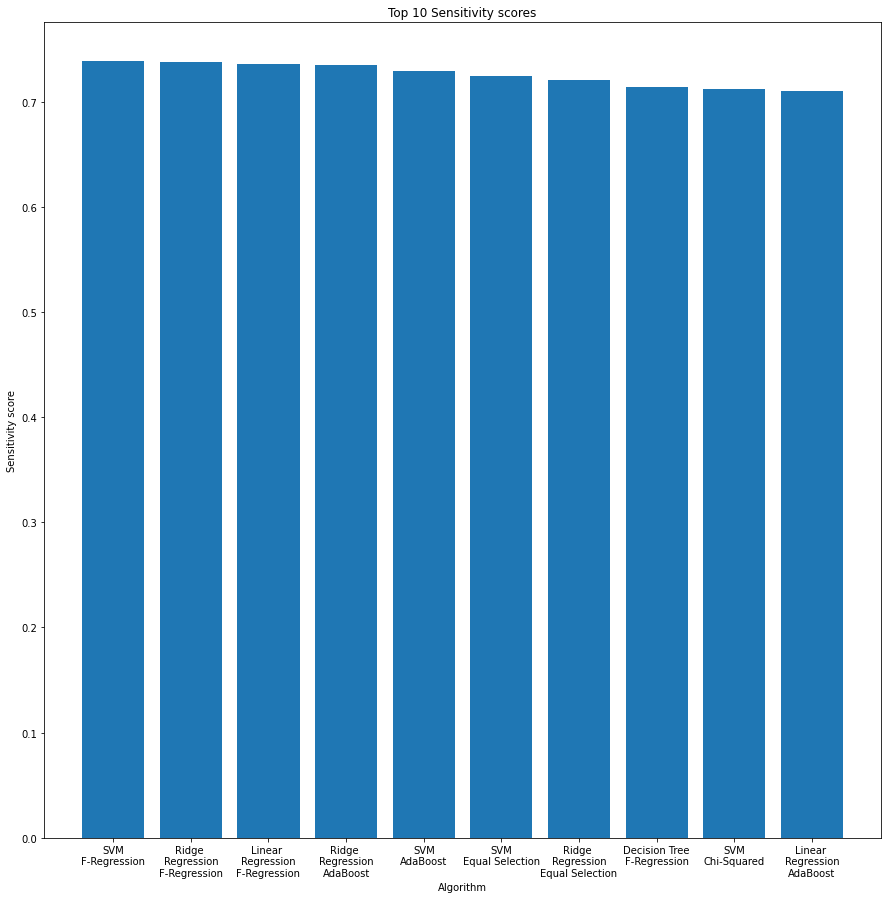

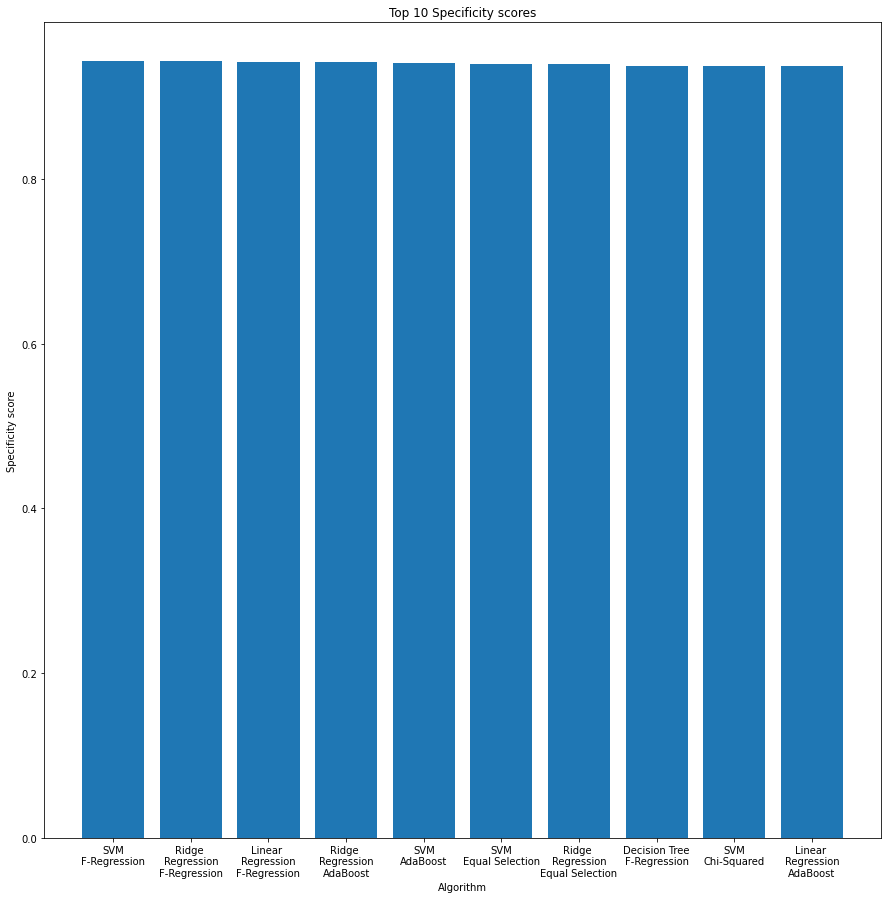

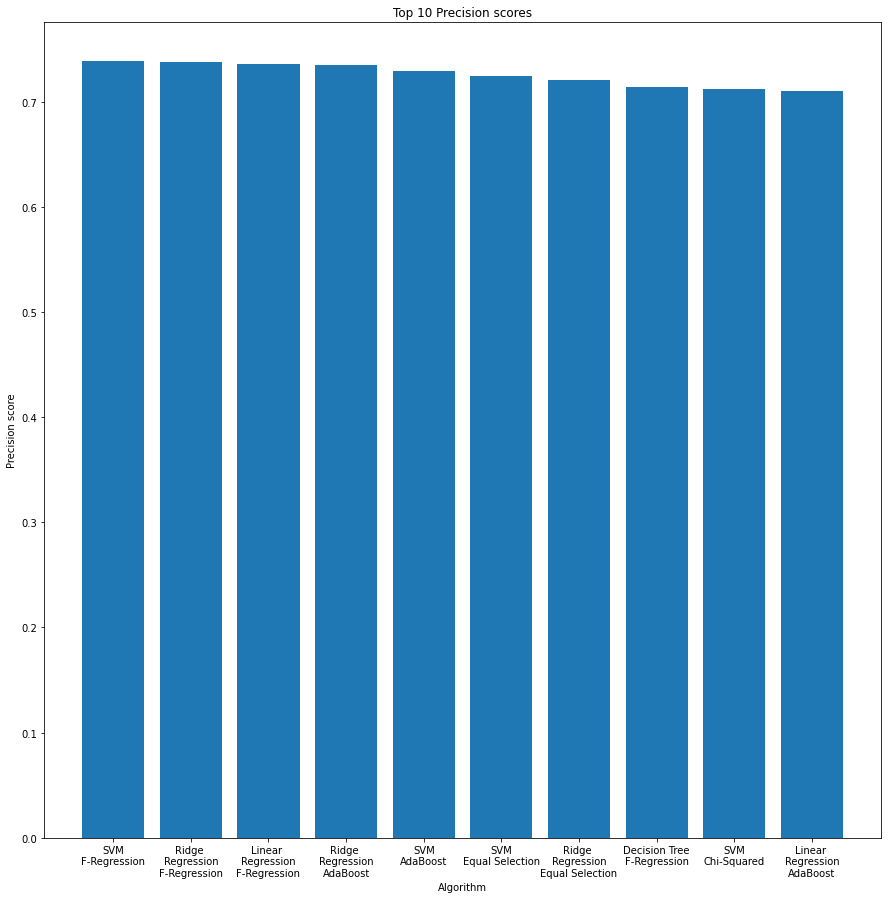

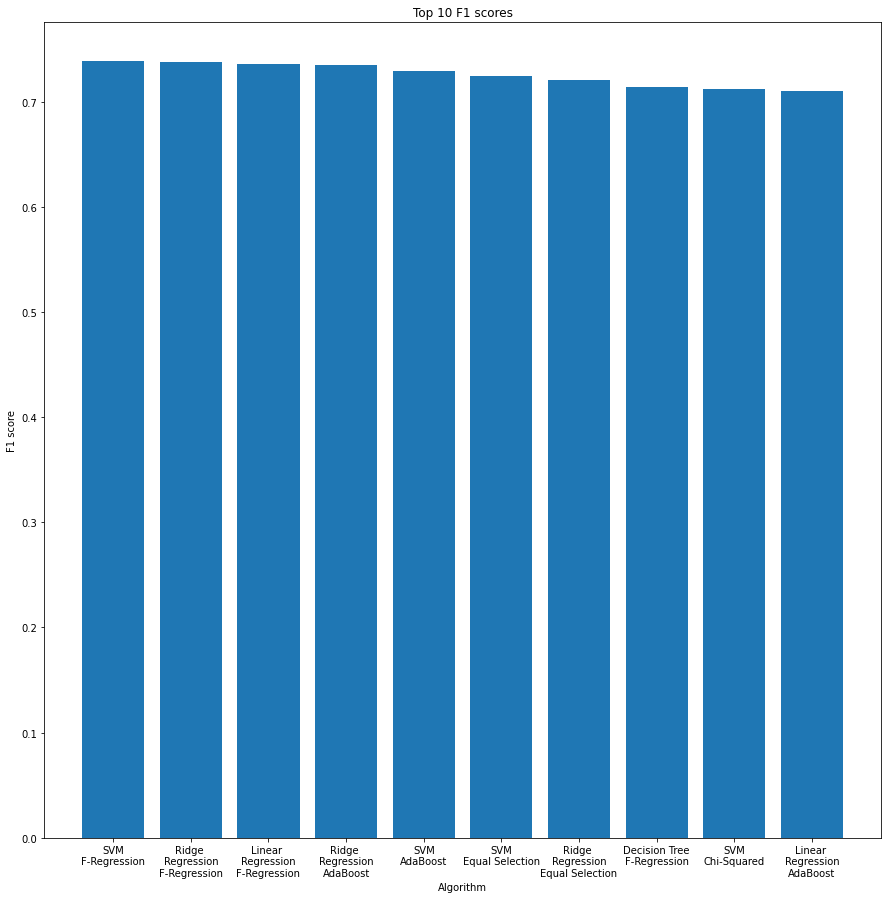

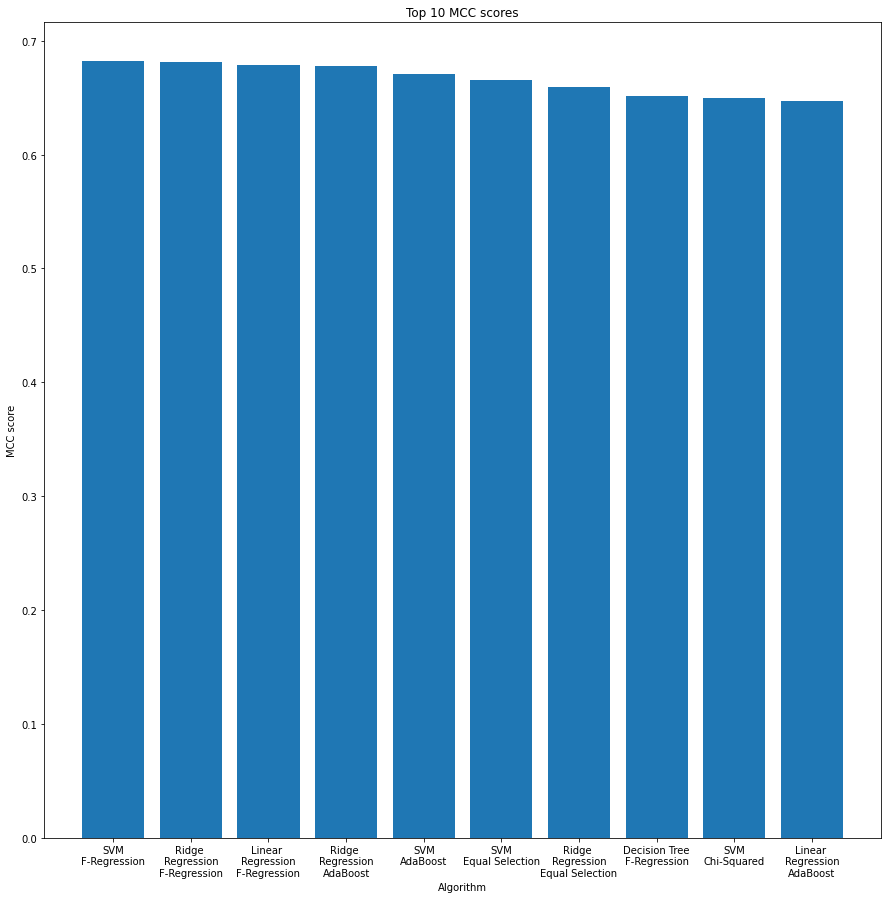

In [57]:
for metric in SCORE_KEYS:
    top_x = 10
    best_x_scores(metric,top_x)